In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 16.3 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.25
batch_size_value = 32
n_repeats = 3
n_epochs = 50
lr = 1e-3
# noise = 'topological'
noise = 'salt&pepper'
# noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 0s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'gaussian':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:06<00:00, 1479.20it/s]



gaussian noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 1480.53it/s]


gaussian noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

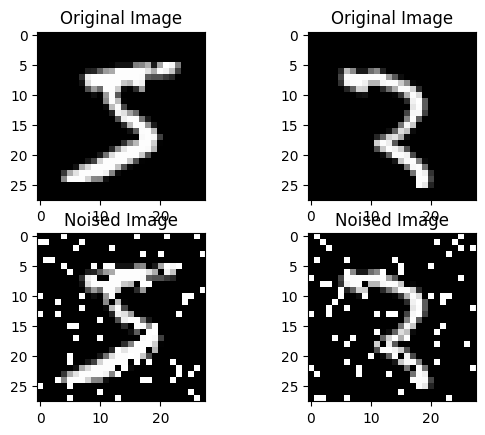

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

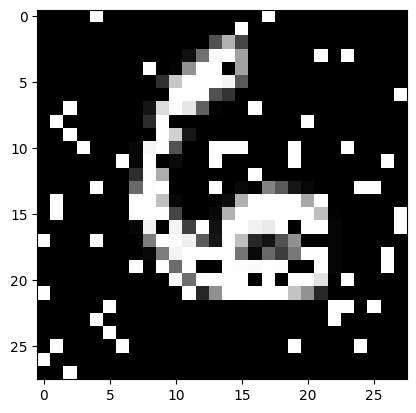

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

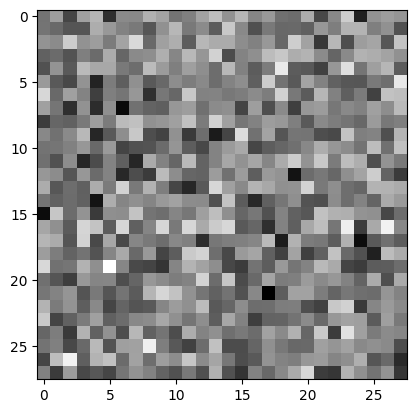

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(743.0777, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

5165.55615234375

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0156,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


  0 7199.4639 5223.7900


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


  1 6137.4868 5214.6436


100%|██████████| 313/313 [02:37<00:00,  1.98it/s]


  2 5854.9199 5199.7637


100%|██████████| 313/313 [02:39<00:00,  1.97it/s]


  3 5734.1240 5179.7349


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


  4 5662.8428 5167.6953


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


  5 5612.7905 5154.1567


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  6 5582.8306 5141.4570


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


  7 5564.5977 5131.9814


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


  8 5552.5454 5128.3984


100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


  9 5543.0752 5124.8667


100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


 10 5535.0625 5122.2324


100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


 11 5528.4707 5120.7114


100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


 12 5522.3740 5116.1260


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 13 5517.2832 5114.4937


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 14 5513.6143 5112.9497


100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


 15 5510.6187 5112.1392


100%|██████████| 313/313 [02:38<00:00,  1.98it/s]


 16 5506.3442 5110.3159


100%|██████████| 313/313 [02:38<00:00,  1.98it/s]


 17 5504.8472 5108.2798


100%|██████████| 313/313 [02:38<00:00,  1.98it/s]


 18 5501.2402 5107.3496


100%|██████████| 313/313 [02:37<00:00,  1.99it/s]


 19 5498.2954 5106.1719


100%|██████████| 313/313 [02:35<00:00,  2.01it/s]


 20 5496.0430 5105.4287


100%|██████████| 313/313 [02:35<00:00,  2.01it/s]


 21 5491.8354 5103.4722


100%|██████████| 313/313 [02:40<00:00,  1.96it/s]


 22 5491.1284 5102.4751


100%|██████████| 313/313 [02:37<00:00,  1.98it/s]


 23 5488.6699 5102.1631


100%|██████████| 313/313 [02:37<00:00,  1.99it/s]


 24 5484.9189 5101.7427


100%|██████████| 313/313 [02:39<00:00,  1.97it/s]


 25 5483.1753 5100.9199


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 26 5481.8486 5100.8052


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


 27 5480.1772 5099.7007


100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


 28 5477.2256 5098.4658


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 29 5475.3267 5099.0322


100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


 30 5472.3931 5099.0864


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 31 5470.4604 5097.8809


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 32 5467.1885 5098.4463


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


 33 5465.9097 5097.2651


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 34 5462.4019 5097.0425


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 35 5460.7651 5096.7969


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 36 5458.7021 5095.6548


100%|██████████| 313/313 [02:38<00:00,  1.98it/s]


 37 5456.7979 5097.4976


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 38 5455.1094 5096.6382


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 39 5452.3462 5096.7026


100%|██████████| 313/313 [02:37<00:00,  1.99it/s]


 40 5450.0903 5096.1318


100%|██████████| 313/313 [02:37<00:00,  1.99it/s]


 41 5447.2461 5096.6772


100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


 42 5446.8306 5096.5342


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 43 5444.9189 5096.3608


100%|██████████| 313/313 [02:37<00:00,  1.98it/s]


 44 5442.2295 5096.7798


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 45 5441.0039 5096.1392


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


 46 5438.5078 5096.7002


100%|██████████| 313/313 [02:42<00:00,  1.92it/s]


 47 5438.5703 5095.4673


100%|██████████| 313/313 [02:38<00:00,  1.98it/s]


 48 5435.8320 5095.9990


100%|██████████| 313/313 [02:38<00:00,  1.98it/s]


 49 5433.0439 5095.8745

  2 MSE    Topo  


100%|██████████| 313/313 [02:47<00:00,  1.87it/s]


  0 7189.0513 5233.7163


100%|██████████| 313/313 [02:48<00:00,  1.85it/s]


  1 6101.8989 5226.6099


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


  2 5835.9087 5215.6899


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


  3 5711.0996 5193.0791


100%|██████████| 313/313 [02:40<00:00,  1.96it/s]


  4 5643.1968 5168.0264


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


  5 5602.8921 5148.7549


100%|██████████| 313/313 [02:39<00:00,  1.97it/s]


  6 5579.3345 5140.9272


100%|██████████| 313/313 [02:39<00:00,  1.97it/s]


  7 5564.2056 5133.0327


100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


  8 5552.5073 5128.6631


100%|██████████| 313/313 [02:38<00:00,  1.98it/s]


  9 5544.1504 5124.6538


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 10 5536.2148 5121.8818


100%|██████████| 313/313 [02:45<00:00,  1.90it/s]


 11 5530.1367 5119.0928


100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


 12 5526.7441 5116.4155


100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


 13 5522.3018 5114.7842


100%|██████████| 313/313 [02:46<00:00,  1.88it/s]


 14 5517.2612 5111.9365


100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


 15 5513.9097 5109.6021


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 16 5511.5000 5108.8945


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 17 5508.0752 5107.0718


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 18 5506.5610 5106.7446


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


 19 5502.9546 5103.9058


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 20 5501.3296 5104.1934


100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


 21 5499.3716 5103.8271


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 22 5496.4355 5101.4502


100%|██████████| 313/313 [02:41<00:00,  1.93it/s]


 23 5495.0791 5101.2559


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


 24 5492.9048 5100.5063


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


 25 5490.8594 5099.0195


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


 26 5488.8169 5099.6392


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


 27 5486.3213 5098.5864


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 28 5483.7188 5098.6489


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


 29 5481.9873 5097.6152


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 30 5479.3530 5097.2534


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 31 5478.4321 5097.7339


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


 32 5474.3062 5097.2031


100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


 33 5472.1284 5097.6079


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


 34 5469.4771 5096.2729


100%|██████████| 313/313 [02:38<00:00,  1.98it/s]


 35 5468.3003 5096.4834


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 36 5464.5186 5096.2231


100%|██████████| 313/313 [02:44<00:00,  1.91it/s]


 37 5462.4194 5096.7612


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


 38 5460.3594 5097.1831


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


 39 5456.9849 5096.5791


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 40 5456.2158 5096.3467


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


 41 5453.0283 5096.6792


100%|██████████| 313/313 [02:41<00:00,  1.93it/s]


 42 5451.8940 5095.6064


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 43 5447.6992 5095.7466


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


 44 5446.9141 5096.1943


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


 45 5443.7427 5095.0791


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 46 5443.8120 5095.0928


100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


 47 5440.0562 5096.4370


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


 48 5439.4731 5095.8696


100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


 49 5436.8589 5095.7710

  3 MSE    Topo  


100%|██████████| 313/313 [02:47<00:00,  1.86it/s]


  0 7210.7222 5248.3516


100%|██████████| 313/313 [02:46<00:00,  1.88it/s]


  1 6107.7598 5234.0000


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


  2 5826.6592 5216.3716


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


  3 5707.7739 5192.9688


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


  4 5639.4062 5165.3696


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


  5 5599.9604 5146.5996


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


  6 5578.3608 5135.8882


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


  7 5564.7334 5129.0986


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


  8 5555.3320 5124.9067


100%|██████████| 313/313 [02:39<00:00,  1.97it/s]


  9 5547.7866 5122.0713


100%|██████████| 313/313 [02:39<00:00,  1.97it/s]


 10 5540.3579 5118.1206


100%|██████████| 313/313 [02:38<00:00,  1.98it/s]


 11 5535.4990 5116.0854


100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


 12 5531.5039 5114.1074


100%|██████████| 313/313 [02:37<00:00,  1.99it/s]


 13 5528.2437 5109.8682


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 14 5524.5122 5111.3062


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


 15 5519.9272 5108.8286


100%|██████████| 313/313 [02:46<00:00,  1.88it/s]


 16 5517.4751 5107.0400


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 17 5513.6655 5106.4507


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 18 5511.7017 5105.9570


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 19 5509.6318 5104.5078


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 20 5506.2915 5103.8872


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 21 5503.0039 5101.8418


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 22 5499.8232 5101.7803


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


 23 5497.0601 5100.9912


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 24 5495.3872 5100.6055


100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


 25 5491.6836 5098.7402


100%|██████████| 313/313 [02:41<00:00,  1.93it/s]


 26 5489.2739 5098.6733


100%|██████████| 313/313 [02:42<00:00,  1.92it/s]


 27 5487.6602 5098.5845


100%|██████████| 313/313 [02:42<00:00,  1.92it/s]


 28 5484.4180 5097.2778


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


 29 5482.3506 5097.1416


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


 30 5480.3931 5097.0474


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


 31 5478.3770 5095.9902


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


 32 5474.7993 5096.0977


100%|██████████| 313/313 [02:41<00:00,  1.93it/s]


 33 5472.7837 5094.9878


100%|██████████| 313/313 [02:41<00:00,  1.93it/s]


 34 5470.4419 5095.7490


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


 35 5467.6392 5094.2891


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 36 5466.7925 5094.4409


100%|██████████| 313/313 [02:42<00:00,  1.92it/s]


 37 5463.5757 5093.9170


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 38 5461.6870 5094.0615


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 39 5459.8657 5093.2485


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 40 5456.0635 5094.4199


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


 41 5455.2578 5094.1768


100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


 42 5452.9243 5093.2749


100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


 43 5450.5879 5094.1421


100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


 44 5448.7661 5094.3179


100%|██████████| 313/313 [02:42<00:00,  1.92it/s]


 45 5447.4458 5094.1895


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


 46 5443.9902 5093.5757


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


 47 5441.7964 5093.6685


100%|██████████| 313/313 [02:42<00:00,  1.92it/s]


 48 5440.4834 5094.6270


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]

 49 5439.4297 5093.5928

CPU times: user 13h 59s, sys: 55.6 s, total: 13h 1min 55s
Wall time: 6h 43min 10s


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

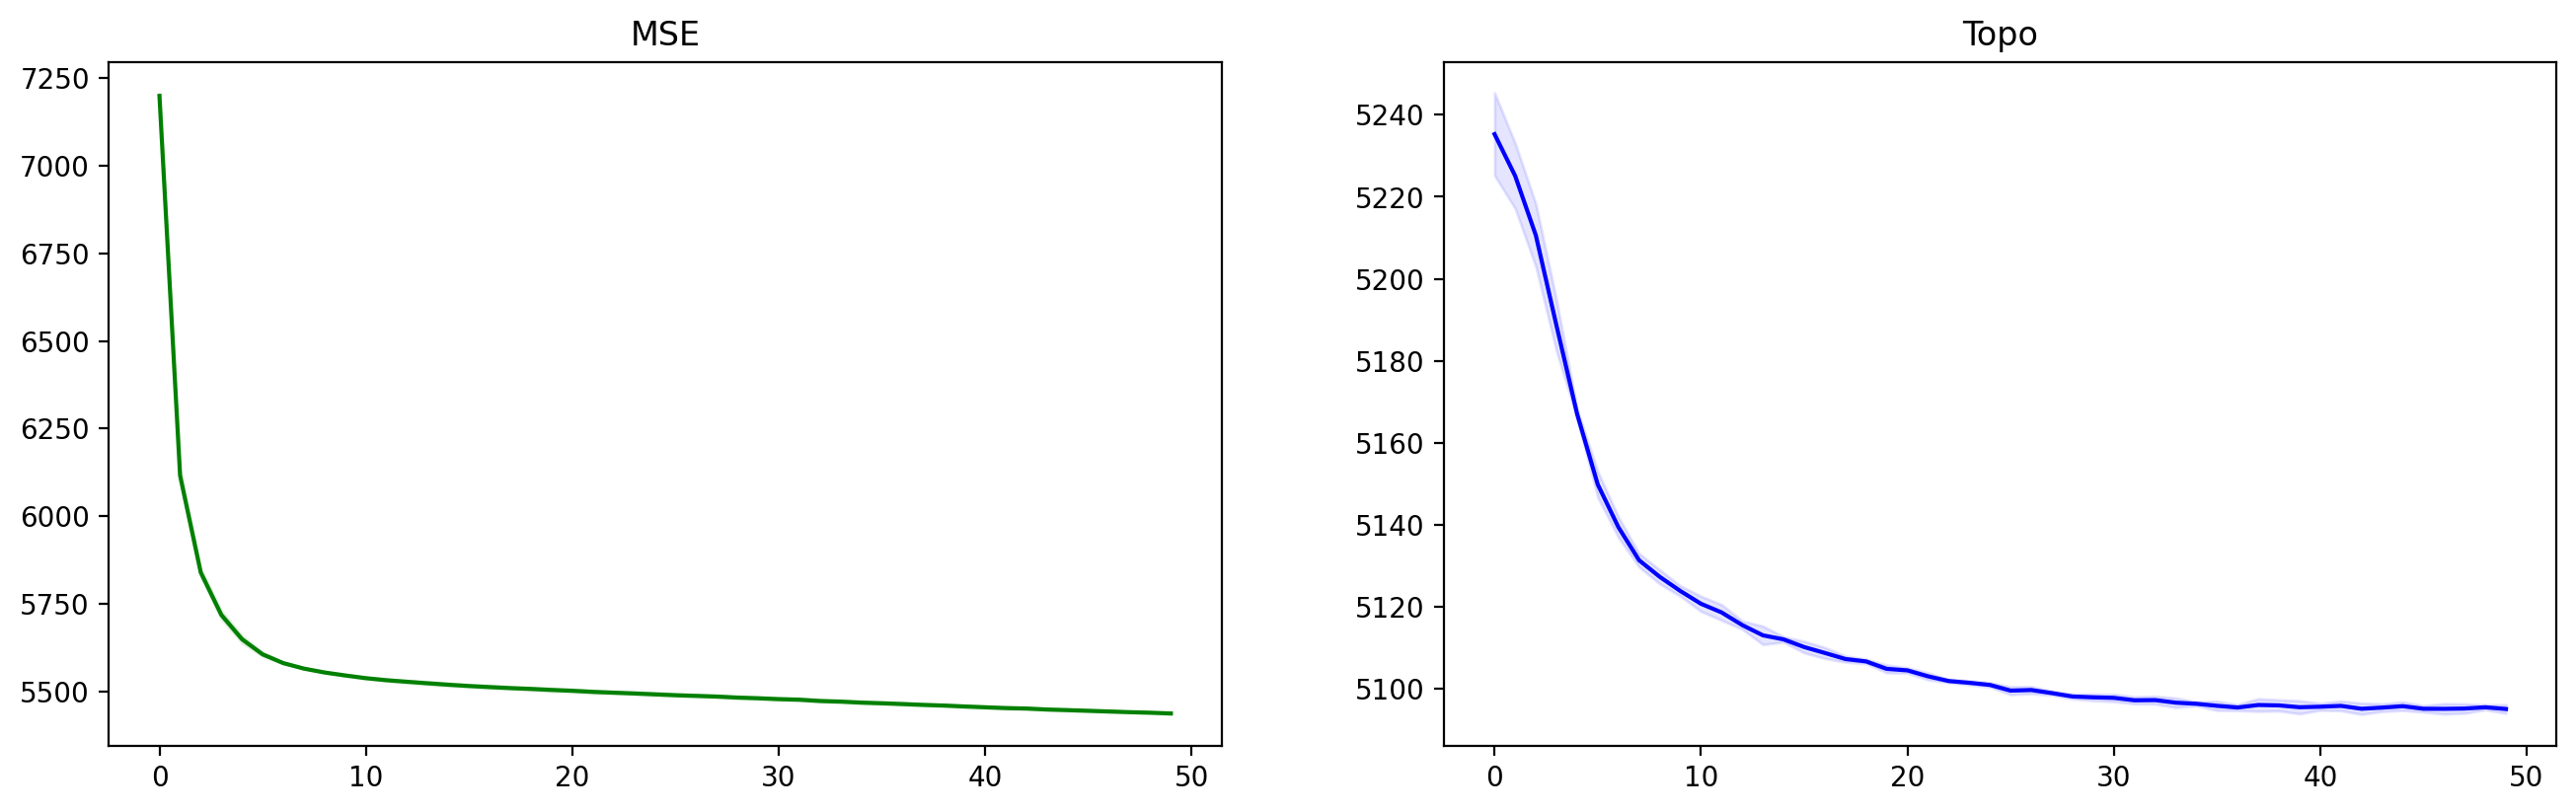

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

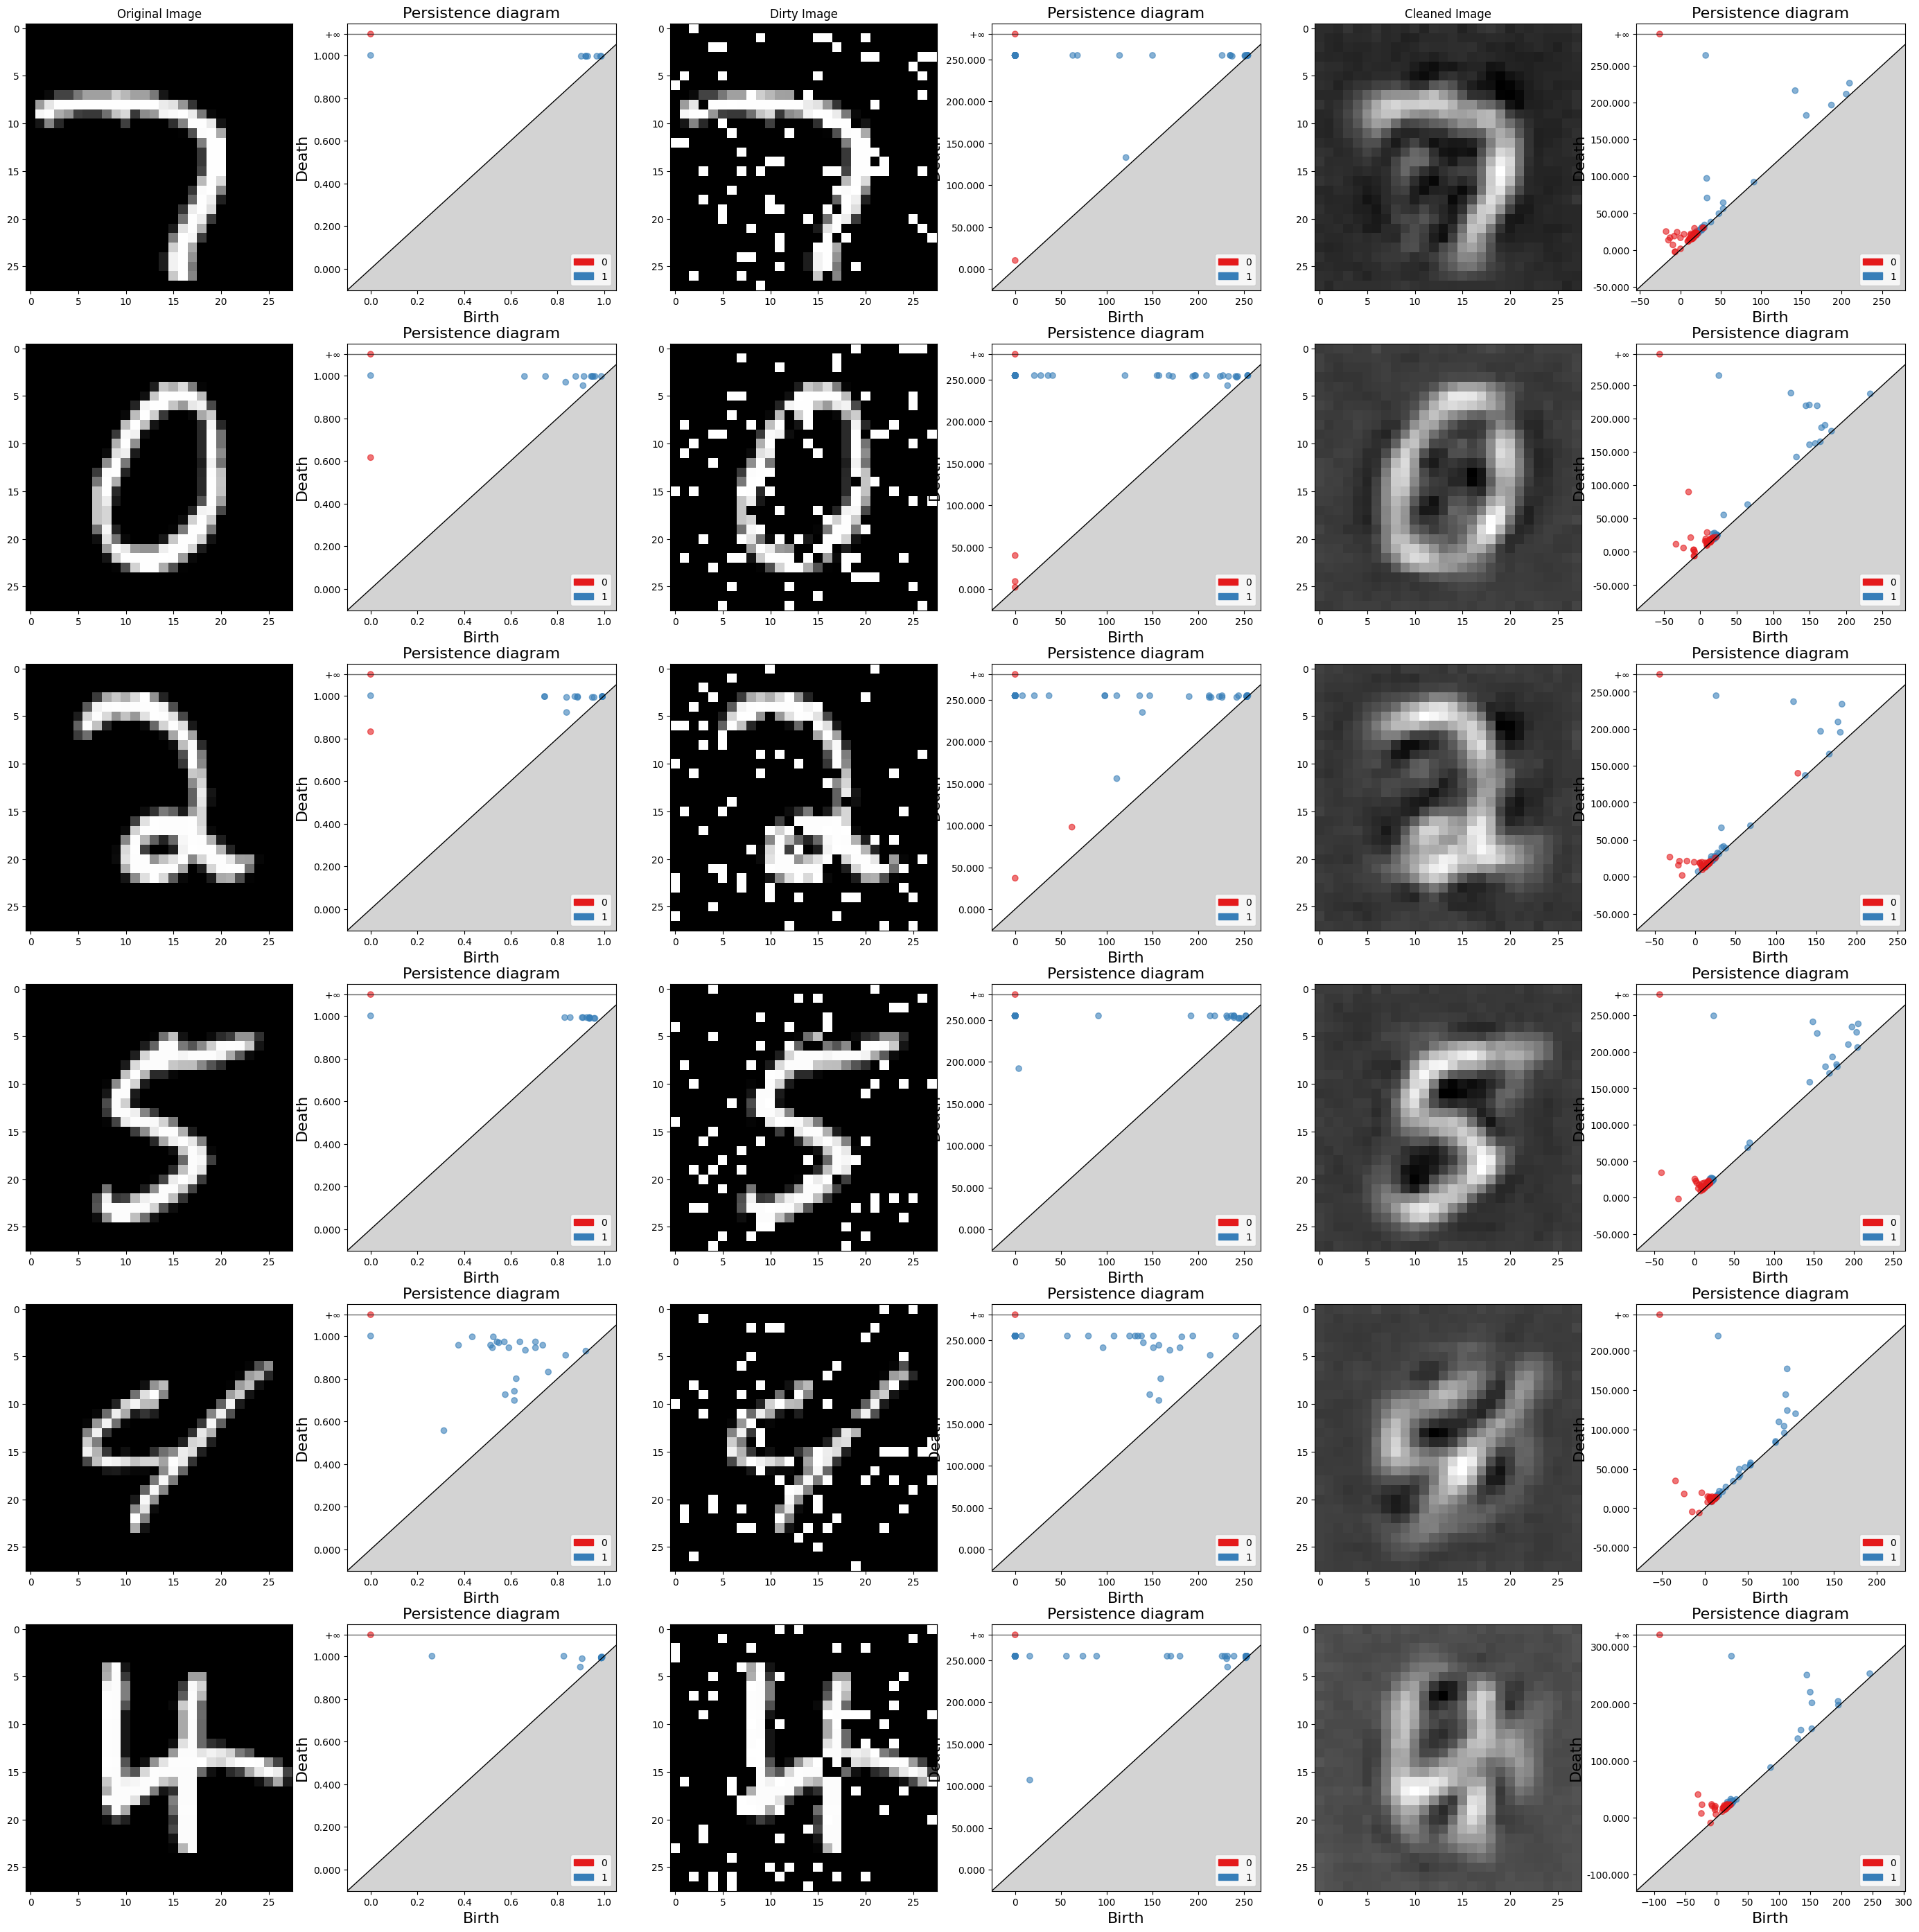

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[7199.46386719 5223.79003906]
  [6137.48681641 5214.64355469]
  [5854.91992188 5199.76367188]
  [5734.12402344 5179.73486328]
  [5662.84277344 5167.6953125 ]
  [5612.79052734 5154.15673828]
  [5582.83056641 5141.45703125]
  [5564.59765625 5131.98144531]
  [5552.54541016 5128.3984375 ]
  [5543.07519531 5124.86669922]
  [5535.0625     5122.23242188]
  [5528.47070312 5120.71142578]
  [5522.37402344 5116.12597656]
  [5517.28320312 5114.49365234]
  [5513.61425781 5112.94970703]
  [5510.61865234 5112.13916016]
  [5506.34423828 5110.31591797]
  [5504.84716797 5108.27978516]
  [5501.24023438 5107.34960938]
  [5498.29541016 5106.171875  ]
  [5496.04296875 5105.42871094]
  [5491.83544922 5103.47216797]
  [5491.12841797 5102.47509766]
  [5488.66992188 5102.16308594]
  [5484.91894531 5101.74267578]
  [5483.17529297 5100.91992188]
  [5481.84863281 5100.80517578]
  [5480.17724609 5099.70068359]
  [5477.22558594 5098.46582031]
  [5475.32666016 5099.03222656]
  [5472.39306641 5099.08642578]
  [5470.